In [144]:
import importlib
import Blackjack_simulator as bjck
importlib.reload(bjck)


<module 'Blackjack_simulator' from 'c:\\Users\\chuck\\Desktop\\ds543\\git\\BlackJack-RL-DQN\\Blackjack_simulator.py'>

In [145]:
import Blackjack_simulator as bjck
from Blackjack_simulator import deal
from Blackjack_simulator import draw
import gymnasium as gym
from typing import Optional, Tuple, Union
from gymnasium import logger, spaces

import math
import random
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [146]:
class BlackJackEnv(gym.Env):
    def __init__(self):
        super(BlackJackEnv, self).__init__()
        self.action_space = gym.spaces.Discrete(2)  # Hit or Stand
        self.observation_space = gym.spaces.Box(low=np.array([0, 0, 1]), high=np.array([21, 4, 11]), dtype=np.float32)
        self.reset()  # Initialize variables properly

    def reset(self):
        self.score, self.hand = deal()
        self.aces = sum(1 for card in self.hand if card == 11)
        self.open_card = draw()
        obs = np.array([self.score, self.aces, self.open_card], dtype=np.float32)
        return obs, {}  # Added info dictionary


    def rewardfnc(self, score):
        if score > 21:
            return -1
        else:
            dealers_total = bjck.dealer_from_hand(self.open_card)
            if score > dealers_total:
                return 1
            elif score < dealers_total:
                return -1
            else: return 0

    def step(self, action):
        if action == 0:  # Stand
            return np.array([self.score, self.aces, self.open_card], dtype=np.float32), self.rewardfnc(self.score), True, {}
        
        card = draw()
        self.score += card
        if card == 11:
            self.aces += 1

        while self.score > 21 and self.aces > 0:
            self.score -= 10
            self.aces -= 1

        done = self.score > 21
        reward = -1 if done else 0
        return np.array([self.score, self.aces, self.open_card], dtype=np.float32), reward, done, {}

env = BlackJackEnv()

In [147]:
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))


class ReplayMemory:
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)
    
    

In [148]:

env = BlackJackEnv()
num_episodes = 1000
total_reward = 0

for _ in range(num_episodes):
    state = env.reset()
    done = False
    episode_reward = 0
    
    while not done:
        action = env.action_space.sample()  # Choose random action (Hit or Stand)
        next_state, reward, done, _ = env.step(action)
        episode_reward += reward
    
    total_reward += episode_reward

average_reward = total_reward / num_episodes
print(f"Average Reward over {num_episodes} episodes: {average_reward:.4f}")

Average Reward over 1000 episodes: -0.3330


In [149]:
class DQN(nn.Module):
    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(n_observations, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, n_actions)

    def forward(self, x):
        x = F.relu(self.fc1 (x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

In [150]:
GAMMA = 0.99
EPS_START = 1.0
EPS_END = 0.05
TAU = 0.005
n = 1000
LR = 1e-3
EPS_DECAY = 5000
test_array = np.array([[int(128), int(256), int(512)],[int(1e-3), int(1e-4), int(1e-5)],[0.9, 0.95, 0.99],[5000, 10000, 20000]])
batch_idx = 0
LR_idx = 1
discounts_idx = 2
Edecay_idx = 3

# DQN Setup
n_actions = env.action_space.n
n_observations = 3
policy_net = DQN(n_observations, n_actions)
target_net = DQN(n_observations, n_actions)
target_net.load_state_dict(policy_net.state_dict())
optimizer = optim.Adam(policy_net.parameters(), lr=LR)
memory = ReplayMemory(10000)
steps_done = 0

# Epsilon-Greedy Action Selection
def select_action(state):
    global steps_done
    eps_threshold = EPS_END + (EPS_START - EPS_END) * np.exp(-steps_done / EPS_DECAY)
    steps_done += 1
    if random.random() > eps_threshold:
        with torch.no_grad():
            return policy_net(state).argmax(dim=1).view(1, 1)
    else:
        return torch.tensor([[random.randrange(n_actions)]], dtype=torch.long)





In [151]:
def reset_model():
    # Reinitialize the policy and target networks
    global policy_net, target_net, optimizer, memory

    policy_net = DQN(n_observations, n_actions).to(device)  # Reinitialize policy network
    target_net = DQN(n_observations, n_actions).to(device)  # Reinitialize target network
    
    # Ensure target_net starts with the same weights as policy_net
    target_net.load_state_dict(policy_net.state_dict())

    # Reset optimizer
    optimizer = optim.Adam(policy_net.parameters(), lr=LR)
    
    # Clear the replay memory
    memory = ReplayMemory(10000)
    
    # Reset the step count
    global steps_done
    steps_done = 0

    print("Model and replay memory reset.")


In [152]:
def optimize_model(BATCH_SIZE):
    if len(memory) < BATCH_SIZE:
        return

    transitions = memory.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions))

    state_batch = torch.cat(batch.state)  # Shape: (batch_size, n_observations)
    
    # Convert action batch into a tensor
    action_batch = torch.tensor(batch.action, dtype=torch.long, device=device).unsqueeze(1)  # Ensure correct shape

    reward_batch = torch.cat(batch.reward)

    # Create mask for non-final states
    non_final_mask = torch.tensor([s is not None for s in batch.next_state], dtype=torch.bool)
    
    # Get next state values
    if any(s is not None for s in batch.next_state):
        non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])
    else:
        non_final_next_states = torch.zeros((0, *state_batch.shape[1:]), device=device)

    # Get Q-values from policy network for the current state
    state_action_values = policy_net(state_batch).gather(1, action_batch)  # Gathering the action's Q-value

    # Get next state actions using the policy network for action selection
    next_state_actions = policy_net(non_final_next_states).max(1)[1].view(-1, 1)  # Shape: (batch_size, 1)

    # Get the Q-values for the next state using the target network for evaluation
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        # Fix shape mismatch by squeezing the 2D tensor to 1D
        next_state_values[non_final_mask] = target_net(non_final_next_states).gather(1, next_state_actions).squeeze(1)

    # Calculate the expected Q-values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute loss and perform backpropagation
    loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))  # Shape: (batch_size, 1)
    optimizer.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_norm_(policy_net.parameters(), 1)
    optimizer.step()


In [ ]:
import random
def run_model(num_episodes, BATCH_SIZE, LR, GAMMA, EPS_DECAY):
    total_rewards = []
    for episode in range(num_episodes):
        state, _ = env.reset()  # Updated reset() to return tuple
        state = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)
        episode_reward = 0

        for t in count():
            action = select_action(state)
            next_state, reward, done, _ = env.step(action)

            reward = torch.tensor([reward], dtype=torch.float32, device=device)
            next_state = torch.tensor(next_state, dtype=torch.float32).unsqueeze(0).to(device) if not done else None

            memory.push(state, torch.tensor([[action]], device=device), next_state, reward)
            state = next_state

            optimize_model(BATCH_SIZE)

            episode_reward += reward.item()
            if done:
                total_rewards.append(episode_reward)
                break

        if episode % 1000 == 0:
            print(f"in progress{random.randint(1,5) * '.'}")
    return total_rewards

            
def model_search(test_array, n):   
    total_rewards = {}  

    for i_idx, i in enumerate(test_array[batch_idx], 1):  # Start index at 1
        BATCH_SIZE = int(i)
        for j_idx, j in enumerate(test_array[LR_idx], 1):
            LR = float(j)
            for k_idx, k in enumerate(test_array[discounts_idx], 1):    
                GAMMA = float(k)
                for l_idx, l in enumerate(test_array[Edecay_idx], 1):
                    EPS_DECAY = float(l)

                    print(f'Running DQN with batch size index: {i_idx}, learning rate index: {j_idx}, '
                        f'discount factor index: {k_idx}, epsilon decay index: {l_idx}')

                    rewards = run_model(n, BATCH_SIZE, LR, GAMMA, EPS_DECAY)
                    
                    avg_reward = np.mean(rewards[-100:])  # Store last 100 episode average reward
                    
                    # Store indices instead of raw values
                    total_rewards[(i_idx, j_idx, k_idx, l_idx)] = avg_reward  

    return total_rewards


l = model_search(test_array, n)

Running DQN with batch size index: 1, learning rate index: 1, discount factor index: 1, epsilon decay index: 1
in progress.....


KeyboardInterrupt: 

In [154]:
best_hyperparams = max(l, key=l.get)
best_reward = l[best_hyperparams]
idx = 0
print(f'Best Model: {best_hyperparams}, with average reward: {best_reward}')
for i in best_hyperparams:
    print(f'Index: {i}, Value: {test_array[idx][i-1]}')
    idx+=1



Best Model: (3, 2, 2, 1), with average reward: 0.17
Index: 3, Value: 512.0
Index: 2, Value: 0.0
Index: 2, Value: 0.95
Index: 1, Value: 5000.0


In [ ]:
BATCH_SIZE = 512
LR = 1e-4
GAMMA = 0.95
EPS_DECAY = 50000
best_model = run_model(10000, BATCH_SIZE, LR, GAMMA, EPS_DECAY)


in progress....
in progress....
in progress...
in progress..
in progress...
in progress.
in progress.....
in progress.
in progress....
in progress....
in progress.
in progress....
in progress..
in progress....
in progress.....
in progress.
in progress....
in progress..
in progress.
in progress.
in progress..
in progress..
in progress.
in progress.
in progress..
in progress.
in progress....
in progress...
in progress..
in progress.....
in progress....
in progress..
in progress.....
in progress.....
in progress.
in progress.
in progress...
in progress....
in progress.
in progress..
in progress....
in progress.
in progress.....
in progress.
in progress....
in progress...
in progress....
in progress...
in progress....
in progress.....
in progress....
in progress.....
in progress....
in progress.
in progress.
in progress...
in progress.....
in progress..
in progress...
in progress.
in progress.
in progress...
in progress.....
in progress...
in progress.
in progress....
in progress....
in pr

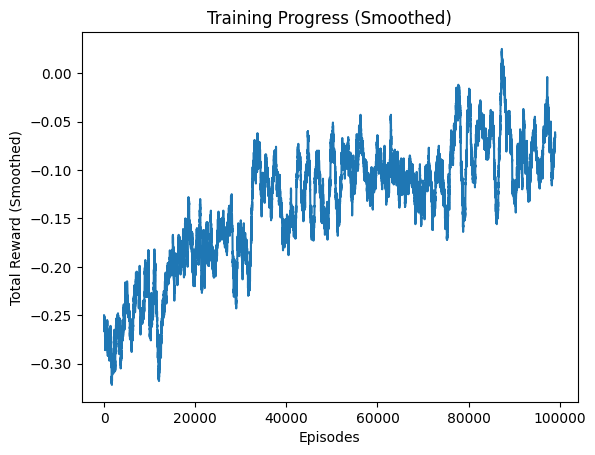

Average total reward for naive DQN: -0.08


In [162]:

def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size) / window_size, mode='valid')

window_size = 1000
smoothed_rewards = moving_average(best_model, window_size)

plt.plot(smoothed_rewards)
plt.xlabel('Episodes')
plt.ylabel('Total Reward (Smoothed)')
plt.title('Training Progress (Smoothed)')
plt.show()

print(f'Average total reward for naive DQN: {np.mean(best_model[-100:])}')

In [ ]:
class Double_DQN(nn.Module):
    def __init__(self, n_observations, n_actions):
        super(Double_DQN, self).__init__()
        self.fc1 = nn.Linear(n_observations, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3_main = nn.Linear(128, n_actions)  # For action selection
        self.fc3_target = nn.Linear(128, n_actions)  # For Q-value evaluation

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        main_output = self.fc3_main(x)  # Output for action selection
        target_output = self.fc3_target(x)  # Output for Q-value evaluation
        return main_output, target_output


In [ ]:
class ReplayMemory:
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)


In [ ]:
def optimize_model(BATCH_SIZE):
    if len(memory) < BATCH_SIZE:
        return

    transitions = memory.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions))

    state_batch = torch.cat(batch.state)  # Shape: (batch_size, n_observations)
    action_batch = torch.cat(batch.action)  # Shape: (batch_size, 1)
    reward_batch = torch.cat(batch.reward)

    # Create mask for non-final states
    non_final_mask = torch.tensor([s is not None for s in batch.next_state], dtype=torch.bool)
    
    # Get next state values
    if any(s is not None for s in batch.next_state):
        non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])
    else:
        non_final_next_states = torch.zeros((0, *state_batch.shape[1:]), device=device)

    # Get Q-values from policy network for the current state
    state_action_values = policy_net(state_batch).gather(1, action_batch)  # Gathering the action's Q-value

    # Get next state actions using the policy network for action selection
    next_state_actions = policy_net(non_final_next_states).max(1)[1].view(-1, 1)  # Shape: (batch_size, 1)

    # Get the Q-values for the next state using the target network for evaluation
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        # Fix shape mismatch by squeezing the 2D tensor to 1D
        next_state_values[non_final_mask] = target_net(non_final_next_states).gather(1, next_state_actions).squeeze(1)

    # Calculate the expected Q-values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute loss and perform backpropagation
    loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))  # Shape: (batch_size, 1)
    optimizer.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_norm_(policy_net.parameters(), 1)
    optimizer.step()


In [ ]:
num_episodes = 10000
total_rewards = []
total_rewards = run_model(num_episodes, BATCH_SIZE, LR, GAMMA, EPS_DECAY)


in progress.
in progress....
in progress....
in progress.
in progress...
in progress.....
in progress..
in progress.....
in progress....
in progress.....


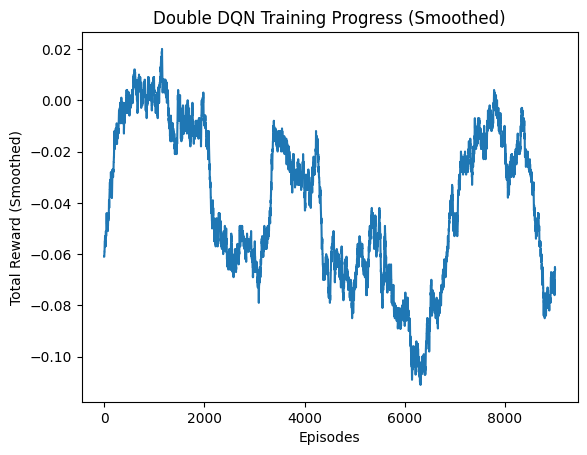

Average total reward for Double DQN: -0.04
Model and replay memory reset.


In [ ]:
window_size = 1000
smoothed_rewards = moving_average(total_rewards, window_size)

plt.plot(smoothed_rewards)
plt.xlabel('Episodes')
plt.ylabel('Total Reward (Smoothed)')
plt.title('Double DQN Training Progress (Smoothed)')
plt.show()

print(f'Average total reward for Double DQN: {np.mean(total_rewards[-100:])}')
reset_model()